In [16]:
def is_start_of_daily_block(date_series):
    """
    Returns a boolean Series indicating if each date in the input Series is the 
    start of a new sequence of consecutive dates.

    :param date_series: Pandas Series with datetime objects.
    :return: Pandas Series of boolean values.
    """
    # Ensure the Series is sorted
    sorted_series = date_series.sort_values()

    # Calculate the difference in days between each date and the previous date
    day_diff = sorted_series.diff().dt.days

    # Mark True where the difference is greater than 1 day, indicating a new sequence
    is_start = day_diff > 1

    # Handle the first element
    if not is_start.empty:
        is_start.iloc[0] = True

    return is_start

In [17]:
import utils

In [18]:
import pickle

In [19]:
import pandas as pd
import re

extruder = 'EX1'

ex_data = pd.read_csv(f"data/{extruder}_processed.csv")
ex_data['Unnamed: 0'] = pd.to_datetime(ex_data['Unnamed: 0'])
ex_data = ex_data.set_index('Unnamed: 0').rename_axis('Date and Time')
#ex_data.index = pd.to_datetime(ex_data.index)
ex_data.dropna(inplace=True)

In [20]:
type(ex_data.index[0])

pandas._libs.tslibs.timestamps.Timestamp

In [21]:
min_time = ex_data.index.min()
well_sampled_cutoff = min_time + pd.Timedelta(hours=48)
min_time, well_sampled_cutoff

ex_data.loc[ex_data.index < well_sampled_cutoff,'well_sampled'] = False

In [22]:
len(ex_data)

519930

In [23]:
#ex_data['Date and Time'] = ex_data.index

In [24]:
for time_window in ['5T', '15T', '30T', '1H', '3H', '6H', '12H', '24H', '48H']:
    if 'T' in time_window:
        label_append = time_window.replace('T', 'min')
    elif 'H' in time_window:
        label_append = time_window.replace('H', 'hour')

    col_label = 'pressure-' + label_append + '_avg'
    ex_data[col_label] = ex_data['Extruder Pressure'].rolling(time_window).mean()

    col_label = 'pressure-' + label_append + '_var'
    ex_data[col_label] = ex_data['Extruder Pressure'].rolling(time_window).var()

In [25]:
ex_data.columns

Index(['Extruder Pressure', 'Screw Speed Output', 'Screw Speed',
       'Extruder Die Temp', 'Extruder Thrust ', 'Feed Screw Current (Amps)',
       'Discharge Conveyor Current (Amps)', 'Discharge Conveyor Speed (%)',
       'sample_gap_minutes', '48H_max_gap_backward', '1H_max_gap_forward',
       'well_sampled', 'HAZARD_CONDITION', 'hours_to_hazard',
       'hazard_within_24h', 'pressure-5min_avg', 'pressure-5min_var',
       'pressure-15min_avg', 'pressure-15min_var', 'pressure-30min_avg',
       'pressure-30min_var', 'pressure-1hour_avg', 'pressure-1hour_var',
       'pressure-3hour_avg', 'pressure-3hour_var', 'pressure-6hour_avg',
       'pressure-6hour_var', 'pressure-12hour_avg', 'pressure-12hour_var',
       'pressure-24hour_avg', 'pressure-24hour_var', 'pressure-48hour_avg',
       'pressure-48hour_var'],
      dtype='object')

In [26]:
variables_to_lag = ['Extruder Die Temp', 'Extruder Thrust ',
                    'Screw Speed Output']

colname_map = {
    'Extruder Die Temp' : 'die_temp-',
    'Extruder Thrust ' : 'thrust-',
    'Screw Speed Output' : 'screw_speed_output-',
}

for time_window in ['15T', '1H', '3H', '6H']:
    if 'T' in time_window:
        label_append = time_window.replace('T', 'min')
    elif 'H' in time_window:
        label_append = time_window.replace('H', 'hour')
    for lagvar in variables_to_lag:
        col_label = colname_map[lagvar] + label_append + '_avg'
        ex_data[col_label] = \
            ex_data[lagvar].rolling(time_window).mean()

In [27]:
target_features = ['hours_to_hazard']
input_features = [
    'Extruder Pressure',
    'Screw Speed Output',
    'Screw Speed',
    'Extruder Die Temp',
    'Extruder Thrust ',
    'pressure-1hour_avg',
    'pressure-12hour_avg',
    'pressure-5min_var',
    'pressure-3hour_var',
    'pressure-6hour_var',
    'die_temp-15min_avg',
    'thrust-15min_avg',
    'die_temp-1hour_avg',
    'thrust-1hour_avg',
    'die_temp-6hour_avg',
    'thrust-6hour_avg',
]

well_sampled_data = ex_data[ex_data['well_sampled'] == True]

hours_threshold = 48

model_input = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][input_features]
model_output = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][target_features]

train_split_cutoff = pd.to_datetime('12/1/2023')
model_input_train = model_input[model_input.index < train_split_cutoff]
model_input_test = model_input[model_input.index >= train_split_cutoff]

model_output_train = model_output[model_output.index < train_split_cutoff]
model_output_test = model_output[model_output.index >= train_split_cutoff]

input variables:
Extruder Pressure
Screw Speed Output
Screw Speed
Extruder Die Temp
Extruder Thrust 
pressure-1hour_avg
pressure-12hour_avg
pressure-5min_var
pressure-3hour_var
pressure-6hour_var
die_temp-15min_avg
thrust-15min_avg
die_temp-1hour_avg
thrust-1hour_avg
die_temp-6hour_avg
thrust-6hour_avg
here first
here

Current Time: 21:58:31
results for target: hours_to_hazard, model: Linear Regression


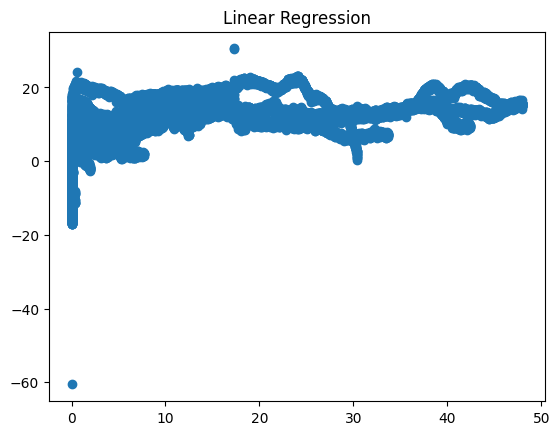

average prediction:  4.435147766562203, std: 7.1105370149574485
min prediction:  -60.61835583607306, max prediction: 30.587108391113922
{'MSE': 68.09208199497014, 'MAE': 6.00833684042757, 'R2': 0.34641393777437535}
--------------------------------------
Run time: 0.01 minutes
Current Time: 21:58:31
--------------------------------------

Current Time: 21:58:31
results for target: hours_to_hazard, model: Ridge


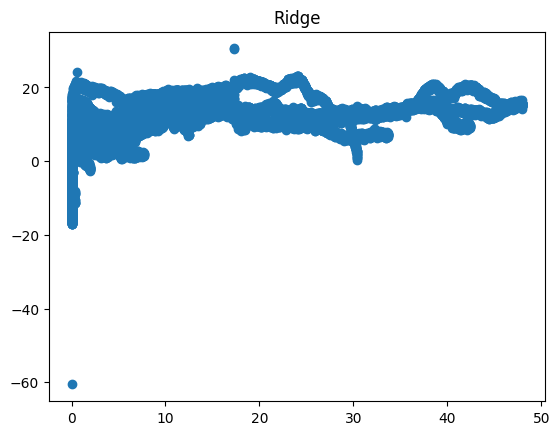

average prediction:  4.435181201736925, std: 7.110514881010481
min prediction:  -60.611136886545445, max prediction: 30.588551909246398
{'MSE': 68.09200132921475, 'MAE': 6.008336811661392, 'R2': 0.3464147120496196}
--------------------------------------
Run time: 0.01 minutes
Current Time: 21:58:32
--------------------------------------

Current Time: 21:58:32
results for target: hours_to_hazard, model: Lasso


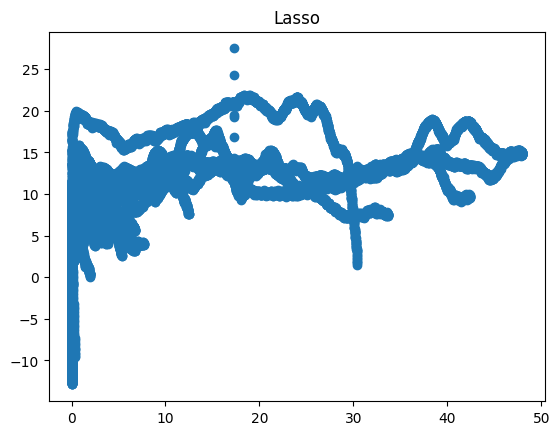

average prediction:  5.416072415761509, std: 6.108143873289531
min prediction:  -12.896821485128093, max prediction: 27.489630073138226
{'MSE': 66.59620199929026, 'MAE': 5.9339765644745786, 'R2': 0.3607722344704688}
--------------------------------------
Run time: 0.02 minutes
Current Time: 21:58:32
--------------------------------------

Current Time: 21:58:32
results for target: hours_to_hazard, model: ElasticNet


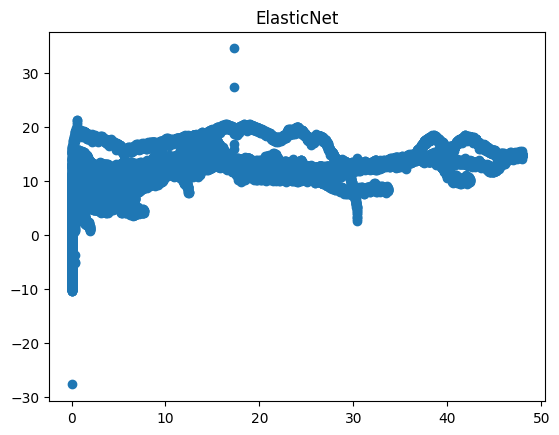

average prediction:  6.25886473640225, std: 5.513592655128247
min prediction:  -27.691973714959797, max prediction: 34.587676889971604
{'MSE': 68.49498126237881, 'MAE': 6.1659953276765265, 'R2': 0.34254668422676515}
--------------------------------------
Run time: 0.02 minutes
Current Time: 21:58:32
--------------------------------------

Current Time: 21:58:32
results for target: hours_to_hazard, model: K-Nearest Neighbors Regressor


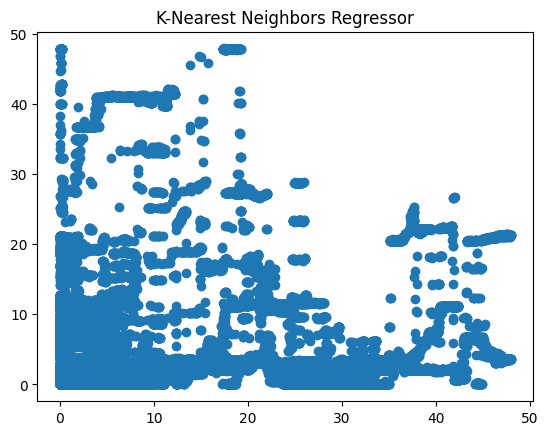

average prediction:  3.7611295858798557, std: 6.994004792954761
min prediction:  0.0, max prediction: 47.89666666666666
{'MSE': 121.16179978084692, 'MAE': 5.897201550453953, 'R2': -0.1629790320816289}
--------------------------------------
Run time: 0.28 minutes
Current Time: 21:58:48
--------------------------------------

Current Time: 21:58:48
results for target: hours_to_hazard, model: Random Forest Regressor


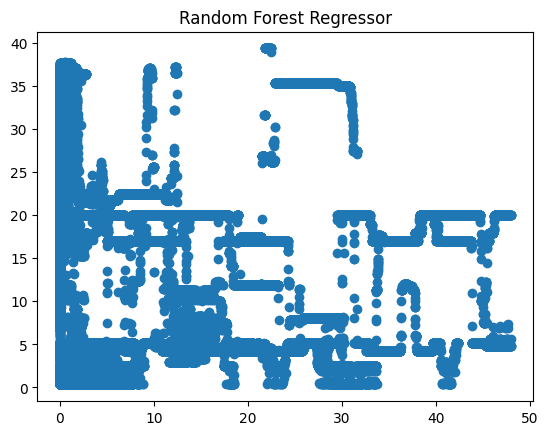

average prediction:  7.139006804975164, std: 10.185389858090076
min prediction:  0.34530826822950217, max prediction: 39.331200390684906
{'MSE': 166.39570230439244, 'MAE': 7.4171890351216785, 'R2': -0.5971594443011541}
--------------------------------------
Run time: 1.51 minutes
Current Time: 22:00:01
--------------------------------------

Current Time: 22:00:01
results for target: hours_to_hazard, model: Support Vector Regressor


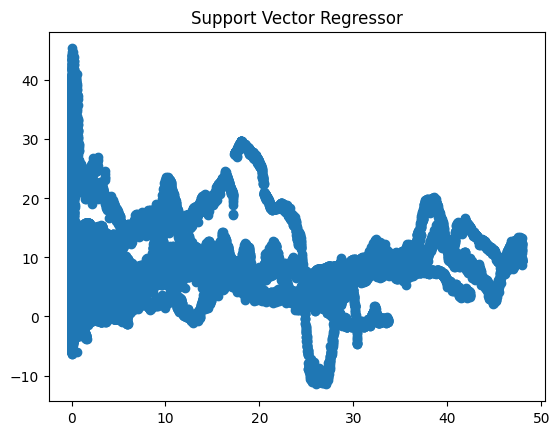

average prediction:  6.150608387185218, std: 6.155966856468349
min prediction:  -11.51863745778358, max prediction: 45.382405048479356
{'MSE': 124.09265408074104, 'MAE': 7.46569615385037, 'R2': -0.19111101842574363}
--------------------------------------
Run time: 38.09 minutes
Current Time: 22:36:36
--------------------------------------

Current Time: 22:36:36
results for target: hours_to_hazard, model: xgboost Regressor


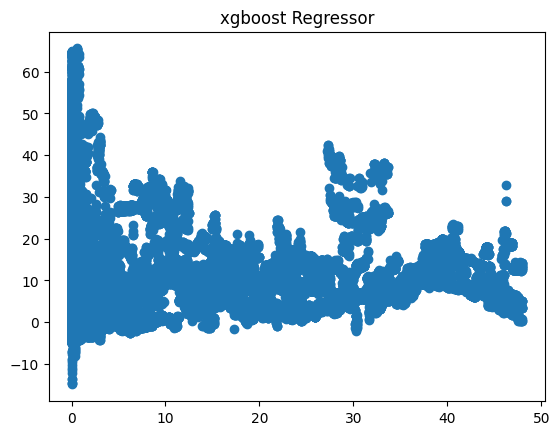

average prediction:  9.905588150024414, std: 12.08443832397461
min prediction:  -14.942919731140137, max prediction: 65.5677719116211
{'MSE': 266.01207511899156, 'MAE': 10.795870357428688, 'R2': -1.5533333625241723}
--------------------------------------
Run time: 38.10 minutes
Current Time: 22:36:37
--------------------------------------

Current Time: 22:36:37
results for target: hours_to_hazard, model: MLP Regressor


/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


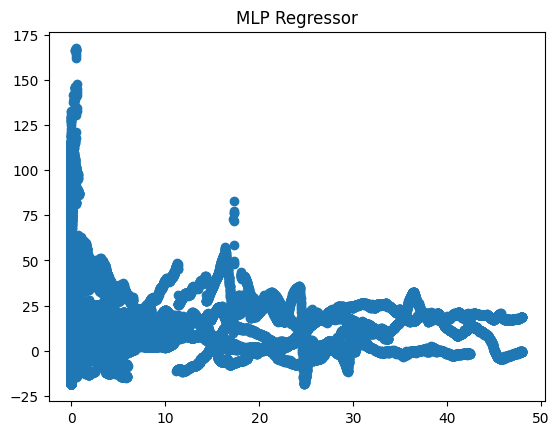

average prediction:  13.006675174706226, std: 20.239899388336568
min prediction:  -18.738069558420364, max prediction: 167.4343016286559
{'MSE': 596.6871436552954, 'MAE': 15.732518489569161, 'R2': -4.727338468386497}
--------------------------------------
Run time: 39.19 minutes
Current Time: 22:37:42
--------------------------------------


In [28]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from xgboost import XGBRegressor

from sklearn.linear_model import Ridge


from sklearn.preprocessing import MinMaxScaler, StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

import time


print('input variables:')
for var in model_input.columns:
    print(var)

print('here first')
# Define the models to test
models = {
    'Linear Regression': LinearRegression(),
    'Ridge' : Ridge(alpha=1.0),
    'Lasso' : Lasso(alpha=1.0),
    'ElasticNet' : ElasticNet(alpha=1.0, l1_ratio=0.5),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Random Forest Regressor': RandomForestRegressor(max_depth=5, min_samples_split=4, min_samples_leaf=2),
    'Support Vector Regressor': SVR(C=1.0),
    'xgboost Regressor': XGBRegressor(reg_alpha=1, reg_lambda=2),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(16, 32), alpha=0.001)
}

print('here')

# Dictionary to hold the results
results = {}
output_models = {}

saved_processed_data = {}

# Iterate over the models, fit, and evaluate them
start_time = time.time()
results = dict()

targ = 'hours_to_hazard'

results[targ] = dict()
output_models[targ] = dict()
#y = model_output[targ].values

X_train = model_input_train[model_output_train[targ].notnull()].values
X_test = model_input_test[model_output_test[targ].notnull()].values

#scaler = MinMaxScaler()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
output_models['_scaling'] = scaler

Y_train = model_output_train[model_output_train[targ].notnull()][targ].values
Y_test = model_output_test[model_output_test[targ].notnull()][targ].values

# Split the data into training and testing sets
#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#n_true = np.sum((Y_train == 1))
#n_false = np.sum((Y_train == 0))

#print(f'balanced true samples: {n_true}, balanced false samples: {n_false}')
for name, model in models.items():
    print()
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print(f'results for target: {targ}, model: {name}')
    model.fit(X_train, Y_train)
    output_models[targ][name] = model

    predictions = model.predict(X_test)
    
    plt.scatter(Y_test, predictions)
    plt.title(f'{name}')
    plt.show()
    
    print(f'average prediction:  {np.mean(predictions)}, std: {np.std(predictions)}')
    print(f'min prediction:  {np.min(predictions)}, max prediction: {np.max(predictions)}')
    
    mse = mean_squared_error(Y_test, predictions)
    mae = mean_absolute_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)
    
    results[targ][name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

    print(results[targ][name])
    print('--------------------------------------')

    duration = time.time() - start_time
    print(f"Run time: {duration / 60:.2f} minutes")
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print('--------------------------------------')

with open(f'models/regression_models_with_screw_speed_with_normalization_added_regularization_{extruder}_{hours_threshold}H.pkl', 'wb') as f:
    pickle.dump((output_models, results, input_features, target_features), f)

In [17]:
!pip install tensorflow-gpu

In [18]:
import tensorflow

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
#min_datetime = pauses.min() - pd.Timedelta(days=7)
#max_datetime = pauses.max()#

#time_mask = (ex_data.index >= min_datetime) \
#            & (ex_data.index <= max_datetime)
#ex_data = ex_data[time_mask]#
#
#ex_data = ex_data[redundancy_mask]

In [37]:
target_feature = ['hours_to_hazard']
input_features = [
    'Screw Speed Output',
    'Screw Speed',
    'Extruder Die Temp',
    'Extruder Thrust ',
    'Feed Screw Current (Amps)',
    'Discharge Conveyor Current (Amps)',
    'Discharge Conveyor Speed (%)',
    'pressure-5min_avg',
    'pressure-15min_avg',
    'pressure-30min_avg',
    'pressure-1hour_avg',
    'pressure-3hour_avg',
    'pressure-6hour_avg',
    'pressure-12hour_avg',
    'pressure-24hour_avg',
    'pressure-48hour_avg',
    'pressure-5min_var',
    'pressure-15min_var',
    'pressure-30min_var',
    'pressure-1hour_var',
    'pressure-3hour_var',
    'pressure-6hour_var',
    'pressure-12hour_var',
    'pressure-24hour_var',
    'pressure-48hour_var',
    'die_temp-15min_avg',
    'thrust-15min_avg',
    'die_temp-1hour_avg',
    'thrust-1hour_avg',
    'die_temp-3hour_avg',
    'thrust-3hour_avg',
    'die_temp-6hour_avg',
    'thrust-6hour_avg',
]

well_sampled_data = ex_data[ex_data['well_sampled'] == True]

hours_threshold = 30

model_input = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][input_features]
model_output = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][target_feature]

train_split_cutoff = pd.to_datetime('12/1/2023')
model_input_train = model_input[model_input.index < train_split_cutoff]
model_input_test = model_input[model_input.index >= train_split_cutoff]

model_output_train = model_output[model_output.index < train_split_cutoff]
model_output_test = model_output[model_output.index >= train_split_cutoff]

input variables:
Screw Speed Output
Screw Speed
Extruder Die Temp
Extruder Thrust 
Feed Screw Current (Amps)
Discharge Conveyor Current (Amps)
Discharge Conveyor Speed (%)
pressure-5min_avg
pressure-15min_avg
pressure-30min_avg
pressure-1hour_avg
pressure-3hour_avg
pressure-6hour_avg
pressure-12hour_avg
pressure-24hour_avg
pressure-48hour_avg
pressure-5min_var
pressure-15min_var
pressure-30min_var
pressure-1hour_var
pressure-3hour_var
pressure-6hour_var
pressure-12hour_var
pressure-24hour_var
pressure-48hour_var
die_temp-15min_avg
thrust-15min_avg
die_temp-1hour_avg
thrust-1hour_avg
die_temp-3hour_avg
thrust-3hour_avg
die_temp-6hour_avg
thrust-6hour_avg
here first
here

Current Time: 14:25:56
results for target: hours_to_hazard, model: Linear Regression


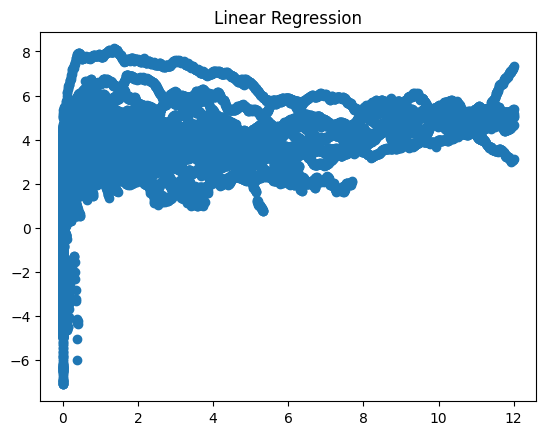

average prediction:  1.8386737252925092, std: 2.1709582615967973
min prediction:  -7.116937482908483, max prediction: 8.136700261385194
{'MSE': 5.778070126965876, 'MAE': 2.0402487947293757, 'R2': -0.10063058569866423}
--------------------------------------
Run time: 0.01 minutes
Current Time: 14:25:56
--------------------------------------

Current Time: 14:25:56
results for target: hours_to_hazard, model: K-Nearest Neighbors Regressor


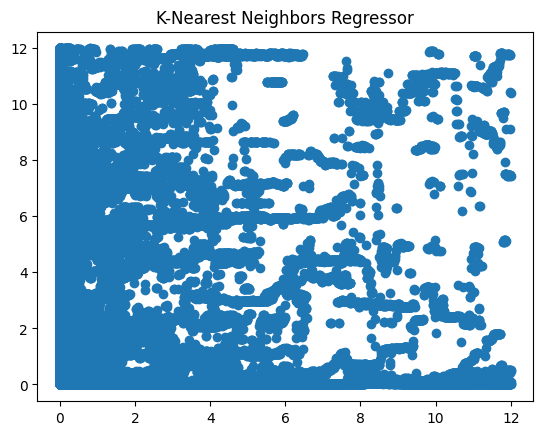

average prediction:  3.11042445002125, std: 3.478015031660533
min prediction:  0.0, max prediction: 11.983333333333334
{'MSE': 21.043304772301042, 'MAE': 3.186019391768365, 'R2': -3.0084153268550278}
--------------------------------------
Run time: 0.15 minutes
Current Time: 14:26:05
--------------------------------------

Current Time: 14:26:05
results for target: hours_to_hazard, model: Random Forest Regressor


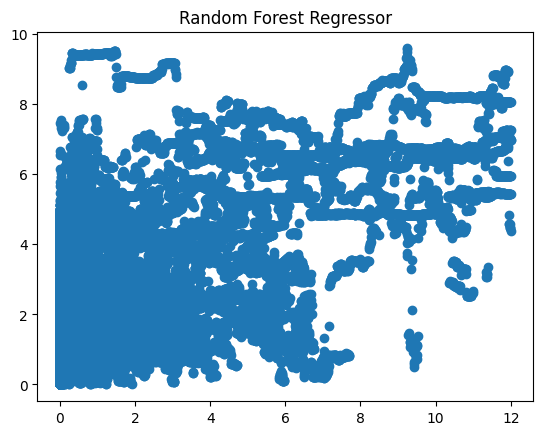

average prediction:  2.637778756248609, std: 2.1602932871103895
min prediction:  0.0, max prediction: 9.589333333333332
{'MSE': 8.498360177972561, 'MAE': 2.1839368738742384, 'R2': -0.6188026338600001}
--------------------------------------
Run time: 4.18 minutes
Current Time: 14:30:06
--------------------------------------

Current Time: 14:30:06
results for target: hours_to_hazard, model: Support Vector Regressor


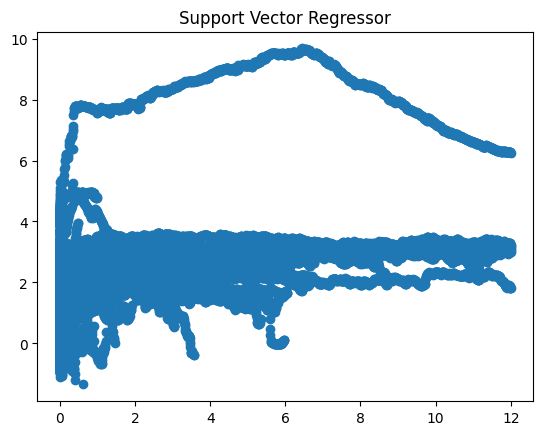

average prediction:  2.316799705471817, std: 1.04742982678693
min prediction:  -1.347902384603284, max prediction: 9.675153822137231
{'MSE': 6.359824435865337, 'MAE': 2.1812375805698174, 'R2': -0.21144554149999917}
--------------------------------------
Run time: 19.54 minutes
Current Time: 14:45:28
--------------------------------------

Current Time: 14:45:28
results for target: hours_to_hazard, model: Gradient Boosting Regressor


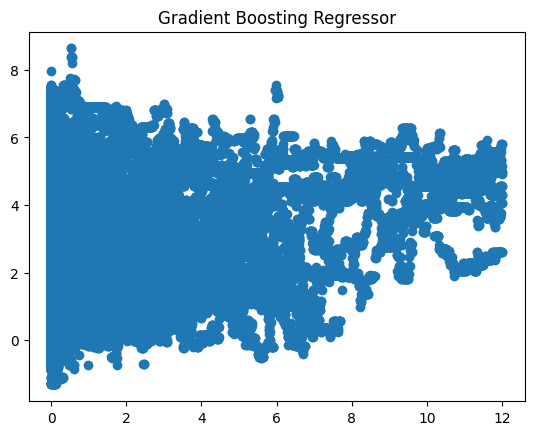

average prediction:  2.7086464614206696, std: 2.179616546306031
min prediction:  -1.3050818064296672, max prediction: 8.629333298481718
{'MSE': 11.097303190121501, 'MAE': 2.540688632072039, 'R2': -1.113859998482365}
--------------------------------------
Run time: 20.89 minutes
Current Time: 14:46:49
--------------------------------------

Current Time: 14:46:49
results for target: hours_to_hazard, model: MLP Regressor


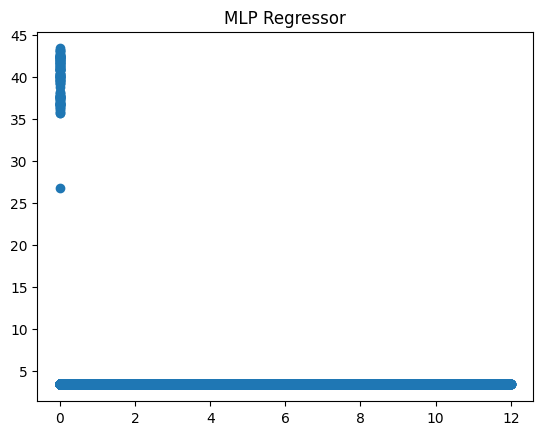

average prediction:  3.3839637877459112, std: 1.1595647676030776
min prediction:  3.3471505339451815, max prediction: 43.40702805743846
{'MSE': 12.214220529576364, 'MAE': 3.1151835139655573, 'R2': -1.3266150115729944}
--------------------------------------
Run time: 21.09 minutes
Current Time: 14:47:01
--------------------------------------


In [44]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import seaborn as sns
import matplotlib.pyplot as plt

import time
import pickle

print('input variables:')
for var in model_input.columns:
    print(var)

print('here first')
# Define the models to test
models = {
    'Linear Regression': LinearRegression(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Support Vector Regressor': SVR(),

    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(16, 32), max_iter=1000)
}

print('here')

# Dictionary to hold the results
results = {}
output_models = {}

saved_processed_data = {}

# Iterate over the models, fit, and evaluate them
start_time = time.time()
results = dict()

targ = 'hours_to_hazard'

results[targ] = dict()
output_models[targ] = dict()
#y = model_output[targ].values

X_train = model_input_train[model_output_train[targ].notnull()].values
X_test = model_input_test[model_output_test[targ].notnull()].values

Y_train = model_output_train[model_output_train[targ].notnull()][targ].values
Y_test = model_output_test[model_output_test[targ].notnull()][targ].values

# Split the data into training and testing sets
#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#n_true = np.sum((Y_train == 1))
#n_false = np.sum((Y_train == 0))

#print(f'balanced true samples: {n_true}, balanced false samples: {n_false}')
for name, model in models.items():
    print()
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print(f'results for target: {targ}, model: {name}')
    model.fit(X_train, Y_train)
    output_models[targ][name] = model

    predictions = model.predict(X_test)
    
    plt.scatter(Y_test, predictions)
    plt.title(f'{name}')
    plt.show()
    
    print(f'average prediction:  {np.mean(predictions)}, std: {np.std(predictions)}')
    print(f'min prediction:  {np.min(predictions)}, max prediction: {np.max(predictions)}')
    
    mse = mean_squared_error(Y_test, predictions)
    mae = mean_absolute_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)
    
    results[targ][name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

    print(results[targ][name])
    print('--------------------------------------')

    duration = time.time() - start_time
    print(f"Run time: {duration / 60:.2f} minutes")
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print('--------------------------------------')

with open(f'models/regression_models_no_screw_speed_{extruder}_{hours_threshold}H.pkl', 'wb') as f:
    pickle.dump((output_models, results), f)

In [ ]:
#with open(f'models/regression_models_no_screw_speed_{extruder}_{hours_threshold}H.pkl', 'wb') as f:
#    pickle.dump((output_models, results), f)

In [12]:
target_features = ['hours_to_hazard']
input_features = [
    'Screw Speed Output',
    'Screw Speed',
    'Extruder Die Temp',
    'Extruder Thrust ',
    'Feed Screw Current (Amps)',
    'Discharge Conveyor Current (Amps)',
    'Discharge Conveyor Speed (%)',
    'pressure-5min_avg',
    'pressure-1hour_avg',
    'pressure-12hour_avg',
    'pressure-5min_var',
    'pressure-3hour_var',
    'pressure-6hour_var',
    'die_temp-15min_avg',
    'thrust-15min_avg',
    'die_temp-1hour_avg',
    'thrust-1hour_avg',
    'die_temp-6hour_avg',
    'thrust-6hour_avg',
]

well_sampled_data = ex_data[ex_data['well_sampled'] == True]

hours_threshold = 30

model_input = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][input_features]
model_output = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][target_features]

train_split_cutoff = pd.to_datetime('12/1/2023')
model_input_train = model_input[model_input.index < train_split_cutoff]
model_input_test = model_input[model_input.index >= train_split_cutoff]

model_output_train = model_output[model_output.index < train_split_cutoff]
model_output_test = model_output[model_output.index >= train_split_cutoff]

input variables:
Screw Speed Output
Screw Speed
Extruder Die Temp
Extruder Thrust 
Feed Screw Current (Amps)
Discharge Conveyor Current (Amps)
Discharge Conveyor Speed (%)
pressure-5min_avg
pressure-1hour_avg
pressure-12hour_avg
pressure-5min_var
pressure-3hour_var
pressure-6hour_var
die_temp-15min_avg
thrust-15min_avg
die_temp-1hour_avg
thrust-1hour_avg
die_temp-6hour_avg
thrust-6hour_avg
here first
here

Current Time: 15:09:47
results for target: hours_to_hazard, model: Linear Regression


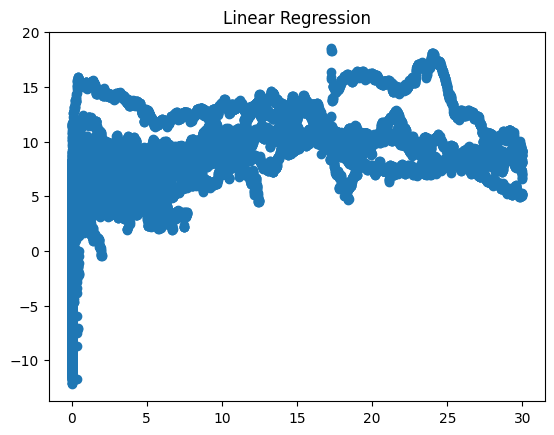

average prediction:  3.4358690342001954, std: 4.689976800050921
min prediction:  -12.20816819061453, max prediction: 18.51994662374365
{'MSE': 29.03395254386151, 'MAE': 3.9701876752922503, 'R2': 0.3361130690698646}
--------------------------------------
Run time: 0.01 minutes
Current Time: 15:09:47
--------------------------------------

Current Time: 15:09:47
results for target: hours_to_hazard, model: K-Nearest Neighbors Regressor


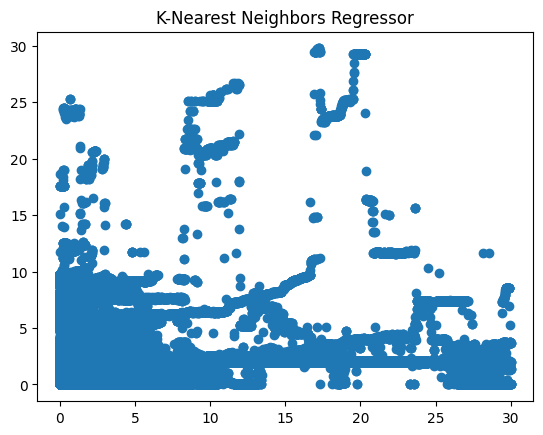

average prediction:  2.8557087382447506, std: 3.954407586389692
min prediction:  0.0, max prediction: 29.77
{'MSE': 53.311421890199874, 'MAE': 4.286302351954734, 'R2': -0.21901267864713536}
--------------------------------------
Run time: 0.21 minutes
Current Time: 15:10:00
--------------------------------------

Current Time: 15:10:00
results for target: hours_to_hazard, model: Random Forest Regressor


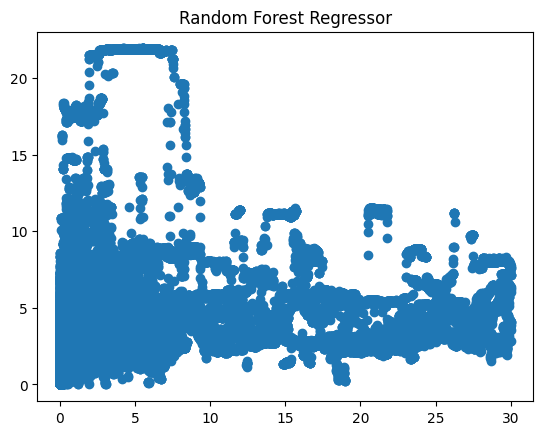

average prediction:  2.1904985062765037, std: 3.090384430366139
min prediction:  0.0, max prediction: 21.930750000000003
{'MSE': 37.630229177575586, 'MAE': 2.961916999191685, 'R2': 0.1395516224958443}
--------------------------------------
Run time: 3.20 minutes
Current Time: 15:12:59
--------------------------------------

Current Time: 15:12:59
results for target: hours_to_hazard, model: Support Vector Regressor


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

import time
import pickle

print('input variables:')
for var in model_input.columns:
    print(var)

print('here first')
# Define the models to test
models = {
    'Linear Regression': LinearRegression(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Support Vector Regressor': SVR(),

    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(16, 32), max_iter=1000)
}

print('here')

# Dictionary to hold the results
results = {}
output_models = {}

saved_processed_data = {}

# Iterate over the models, fit, and evaluate them
start_time = time.time()
results = dict()

targ = 'hours_to_hazard'

results[targ] = dict()
output_models[targ] = dict()
#y = model_output[targ].values

X_train = model_input_train[model_output_train[targ].notnull()].values
X_test = model_input_test[model_output_test[targ].notnull()].values

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
output_models['_scaling'] = scaler

Y_train = model_output_train[model_output_train[targ].notnull()][targ].values
Y_test = model_output_test[model_output_test[targ].notnull()][targ].values

# Split the data into training and testing sets
#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#n_true = np.sum((Y_train == 1))
#n_false = np.sum((Y_train == 0))

#print(f'balanced true samples: {n_true}, balanced false samples: {n_false}')
for name, model in models.items():
    print()
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print(f'results for target: {targ}, model: {name}')
    model.fit(X_train, Y_train)
    output_models[targ][name] = model

    predictions = model.predict(X_test)
    
    plt.scatter(Y_test, predictions)
    plt.title(f'{name}')
    plt.show()
    
    print(f'average prediction:  {np.mean(predictions)}, std: {np.std(predictions)}')
    print(f'min prediction:  {np.min(predictions)}, max prediction: {np.max(predictions)}')
    
    mse = mean_squared_error(Y_test, predictions)
    mae = mean_absolute_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)
    
    results[targ][name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

    print(results[targ][name])
    print('--------------------------------------')

    duration = time.time() - start_time
    print(f"Run time: {duration / 60:.2f} minutes")
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print('--------------------------------------')

with open(f'models/regression_models_no_screw_speed_with_normalization_{extruder}_{hours_threshold}H.pkl', 'wb') as f:
    pickle.dump((output_models, results, input_features, target_features), f)

In [12]:
target_features = ['hours_to_hazard']
input_features = [
    'Screw Speed Output',
    'Screw Speed',
    'Extruder Die Temp',
    'Extruder Thrust ',
    'Feed Screw Current (Amps)',
    'Discharge Conveyor Current (Amps)',
    'Discharge Conveyor Speed (%)',
    'pressure-5min_avg',
    'pressure-1hour_avg',
    'pressure-12hour_avg',
    'pressure-5min_var',
    'pressure-3hour_var',
    'pressure-6hour_var',
    'die_temp-15min_avg',
    'thrust-15min_avg',
    'die_temp-1hour_avg',
    'thrust-1hour_avg',
    'die_temp-6hour_avg',
    'thrust-6hour_avg',
]

well_sampled_data = ex_data[ex_data['well_sampled'] == True]

hours_threshold = 10

model_input = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][input_features]
model_output = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][target_features]

train_split_cutoff = pd.to_datetime('12/1/2023')
model_input_train = model_input[model_input.index < train_split_cutoff]
model_input_test = model_input[model_input.index >= train_split_cutoff]

model_output_train = model_output[model_output.index < train_split_cutoff]
model_output_test = model_output[model_output.index >= train_split_cutoff]

input variables:
Screw Speed Output
Screw Speed
Extruder Die Temp
Extruder Thrust 
Feed Screw Current (Amps)
Discharge Conveyor Current (Amps)
Discharge Conveyor Speed (%)
pressure-5min_avg
pressure-1hour_avg
pressure-12hour_avg
pressure-5min_var
pressure-3hour_var
pressure-6hour_var
die_temp-15min_avg
thrust-15min_avg
die_temp-1hour_avg
thrust-1hour_avg
die_temp-6hour_avg
thrust-6hour_avg
here first
here

Current Time: 15:38:35
results for target: hours_to_hazard, model: Linear Regression


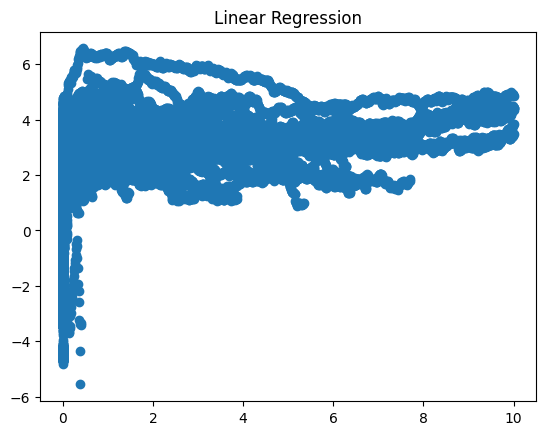

average prediction:  1.6738716742513897, std: 1.6714499044755962
min prediction:  -5.562768946139997, max prediction: 6.569874514554549
{'MSE': 4.1617016141037135, 'MAE': 1.7498548769815874, 'R2': -0.16108124275697033}
--------------------------------------
Run time: 0.01 minutes
Current Time: 15:38:35
--------------------------------------

Current Time: 15:38:35
results for target: hours_to_hazard, model: K-Nearest Neighbors Regressor


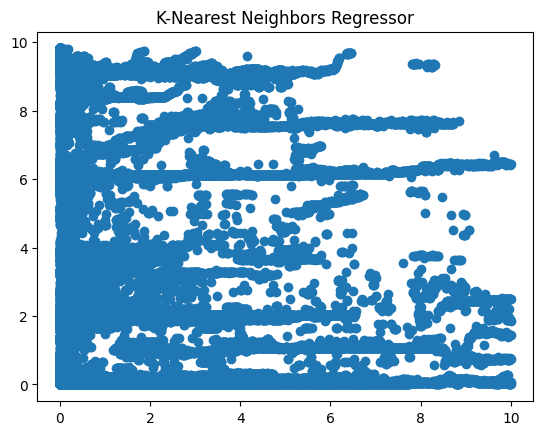

average prediction:  2.527052442129391, std: 3.4255747227093636
min prediction:  0.0, max prediction: 9.816666666666666
{'MSE': 17.24248759636523, 'MAE': 2.565576012435403, 'R2': -3.8105152129992357}
--------------------------------------
Run time: 0.12 minutes
Current Time: 15:38:42
--------------------------------------

Current Time: 15:38:42
results for target: hours_to_hazard, model: Random Forest Regressor


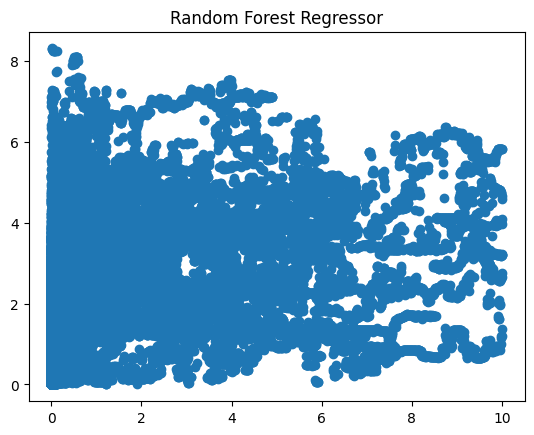

average prediction:  1.1995751305648776, std: 1.6663911479012992
min prediction:  0.0, max prediction: 8.302999999999999
{'MSE': 3.2055042647982113, 'MAE': 0.987484659913666, 'R2': 0.10569011895961367}
--------------------------------------
Run time: 1.98 minutes
Current Time: 15:40:34
--------------------------------------

Current Time: 15:40:34
results for target: hours_to_hazard, model: Support Vector Regressor


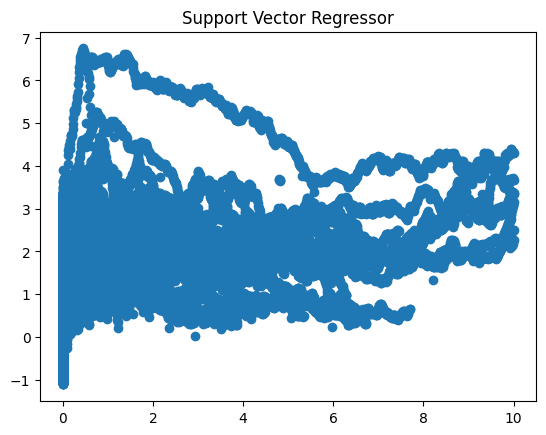

average prediction:  1.0717016123927001, std: 0.9583029472865516
min prediction:  -1.112295658601142, max prediction: 6.747290785910141
{'MSE': 2.629282071544328, 'MAE': 1.0810011536150015, 'R2': 0.2664514714746604}
--------------------------------------
Run time: 13.71 minutes
Current Time: 15:52:17
--------------------------------------

Current Time: 15:52:17
results for target: hours_to_hazard, model: Gradient Boosting Regressor


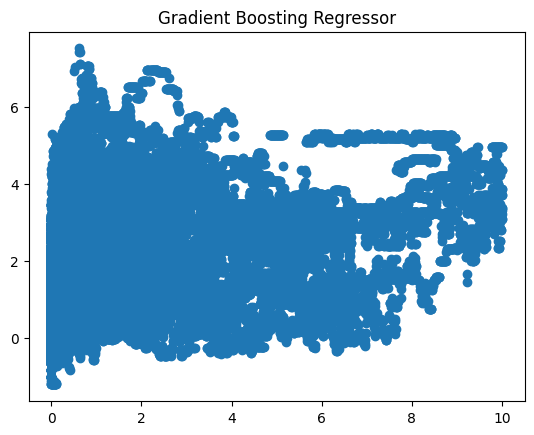

average prediction:  1.0925862963736375, std: 1.3318636393098209
min prediction:  -1.2055303928315673, max prediction: 7.516442882990625
{'MSE': 2.6105056784432206, 'MAE': 1.0426881237340004, 'R2': 0.27168993397337626}
--------------------------------------
Run time: 14.31 minutes
Current Time: 15:52:53
--------------------------------------

Current Time: 15:52:53
results for target: hours_to_hazard, model: MLP Regressor


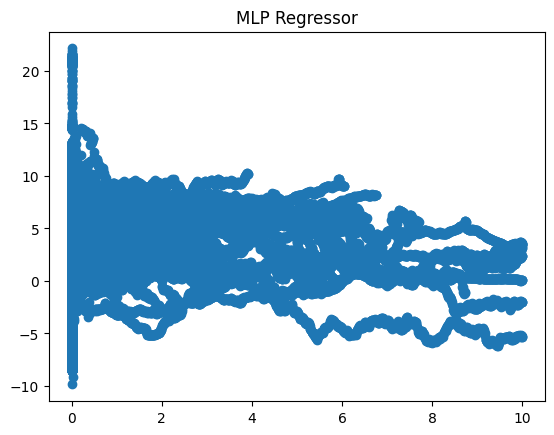

average prediction:  2.3931479021839617, std: 3.6631856307071655
min prediction:  -9.864887424830739, max prediction: 22.14330776545309
{'MSE': 18.50490167402257, 'MAE': 3.2476148873109154, 'R2': -4.162718576448672}
--------------------------------------
Run time: 17.49 minutes
Current Time: 15:56:04
--------------------------------------


In [13]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

import time
import pickle

print('input variables:')
for var in model_input.columns:
    print(var)

print('here first')
# Define the models to test
models = {
    'Linear Regression': LinearRegression(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Support Vector Regressor': SVR(),

    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(16, 32), max_iter=1000)
}

print('here')

# Dictionary to hold the results
results = {}
output_models = {}

saved_processed_data = {}

# Iterate over the models, fit, and evaluate them
start_time = time.time()
results = dict()

targ = 'hours_to_hazard'

results[targ] = dict()
output_models[targ] = dict()
#y = model_output[targ].values

X_train = model_input_train[model_output_train[targ].notnull()].values
X_test = model_input_test[model_output_test[targ].notnull()].values

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
output_models['_scaling'] = scaler

Y_train = model_output_train[model_output_train[targ].notnull()][targ].values
Y_test = model_output_test[model_output_test[targ].notnull()][targ].values

# Split the data into training and testing sets
#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#n_true = np.sum((Y_train == 1))
#n_false = np.sum((Y_train == 0))

#print(f'balanced true samples: {n_true}, balanced false samples: {n_false}')
for name, model in models.items():
    print()
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print(f'results for target: {targ}, model: {name}')
    model.fit(X_train, Y_train)
    output_models[targ][name] = model

    predictions = model.predict(X_test)
    
    plt.scatter(Y_test, predictions)
    plt.title(f'{name}')
    plt.show()
    
    print(f'average prediction:  {np.mean(predictions)}, std: {np.std(predictions)}')
    print(f'min prediction:  {np.min(predictions)}, max prediction: {np.max(predictions)}')
    
    mse = mean_squared_error(Y_test, predictions)
    mae = mean_absolute_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)
    
    results[targ][name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

    print(results[targ][name])
    print('--------------------------------------')

    duration = time.time() - start_time
    print(f"Run time: {duration / 60:.2f} minutes")
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print('--------------------------------------')

with open(f'models/regression_models_no_screw_speed_with_normalization_{extruder}_{hours_threshold}H.pkl', 'wb') as f:
    pickle.dump((output_models, results, input_features, target_features), f)

In [14]:
target_features = ['hours_to_hazard']
input_features = [
    'Screw Speed Output',
    'Screw Speed',
    'Extruder Die Temp',
    'Extruder Thrust ',
    'Feed Screw Current (Amps)',
    'Discharge Conveyor Current (Amps)',
    'Discharge Conveyor Speed (%)',
    'pressure-5min_avg',
    'pressure-1hour_avg',
    'pressure-12hour_avg',
    'pressure-5min_var',
    'pressure-3hour_var',
    'pressure-6hour_var',
    'die_temp-15min_avg',
    'thrust-15min_avg',
    'die_temp-1hour_avg',
    'thrust-1hour_avg',
    'die_temp-6hour_avg',
    'thrust-6hour_avg',
]

well_sampled_data = ex_data[ex_data['well_sampled'] == True]

hours_threshold = 100

model_input = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][input_features]
model_output = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][target_features]

train_split_cutoff = pd.to_datetime('12/1/2023')
model_input_train = model_input[model_input.index < train_split_cutoff]
model_input_test = model_input[model_input.index >= train_split_cutoff]

model_output_train = model_output[model_output.index < train_split_cutoff]
model_output_test = model_output[model_output.index >= train_split_cutoff]

input variables:
Screw Speed Output
Screw Speed
Extruder Die Temp
Extruder Thrust 
Feed Screw Current (Amps)
Discharge Conveyor Current (Amps)
Discharge Conveyor Speed (%)
pressure-5min_avg
pressure-1hour_avg
pressure-12hour_avg
pressure-5min_var
pressure-3hour_var
pressure-6hour_var
die_temp-15min_avg
thrust-15min_avg
die_temp-1hour_avg
thrust-1hour_avg
die_temp-6hour_avg
thrust-6hour_avg
here first
here

Current Time: 19:37:59
results for target: hours_to_hazard, model: Linear Regression


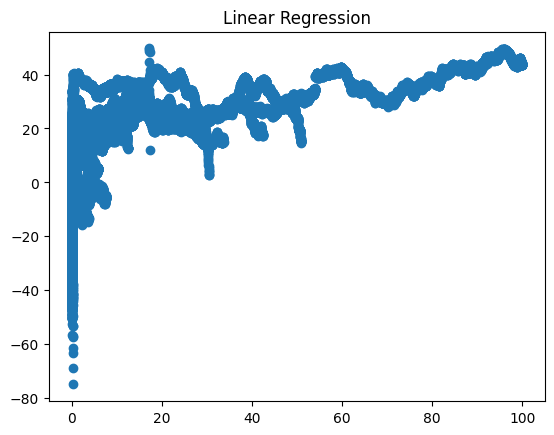

average prediction:  9.075302857681162, std: 17.73956372809761
min prediction:  -75.04127211236865, max prediction: 49.708924032701134
{'MSE': 276.64542548553027, 'MAE': 13.00253871400251, 'R2': 0.1947142284552732}
--------------------------------------
Run time: 0.01 minutes
Current Time: 19:38:00
--------------------------------------

Current Time: 19:38:00
results for target: hours_to_hazard, model: K-Nearest Neighbors Regressor


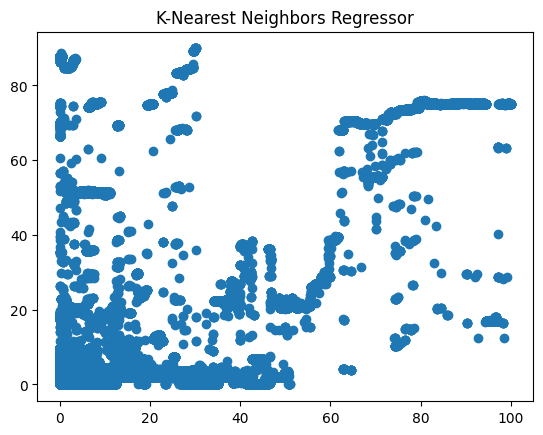

average prediction:  7.705665651147591, std: 17.57855416673343
min prediction:  0.0, max prediction: 89.89333333333335
{'MSE': 266.4182955905495, 'MAE': 8.153105543761848, 'R2': 0.22448432920323758}
--------------------------------------
Run time: 0.37 minutes
Current Time: 19:38:21
--------------------------------------

Current Time: 19:38:21
results for target: hours_to_hazard, model: Random Forest Regressor


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

import time
import pickle

print('input variables:')
for var in model_input.columns:
    print(var)

print('here first')
# Define the models to test
models = {
    'Linear Regression': LinearRegression(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Support Vector Regressor': SVR(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(16, 32), max_iter=1000)
}

print('here')

# Dictionary to hold the results
results = {}
output_models = {}

saved_processed_data = {}

# Iterate over the models, fit, and evaluate them
start_time = time.time()
results = dict()

targ = 'hours_to_hazard'

results[targ] = dict()
output_models[targ] = dict()
#y = model_output[targ].values

X_train = model_input_train[model_output_train[targ].notnull()].values
X_test = model_input_test[model_output_test[targ].notnull()].values

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
output_models['_scaling'] = scaler

Y_train = model_output_train[model_output_train[targ].notnull()][targ].values
Y_test = model_output_test[model_output_test[targ].notnull()][targ].values

# Split the data into training and testing sets
#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#n_true = np.sum((Y_train == 1))
#n_false = np.sum((Y_train == 0))

#print(f'balanced true samples: {n_true}, balanced false samples: {n_false}')
for name, model in models.items():
    print()
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print(f'results for target: {targ}, model: {name}')
    model.fit(X_train, Y_train)
    output_models[targ][name] = model

    predictions = model.predict(X_test)
    
    plt.scatter(Y_test, predictions)
    plt.title(f'{name}')
    plt.show()
    
    print(f'average prediction:  {np.mean(predictions)}, std: {np.std(predictions)}')
    print(f'min prediction:  {np.min(predictions)}, max prediction: {np.max(predictions)}')
    
    mse = mean_squared_error(Y_test, predictions)
    mae = mean_absolute_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)
    
    results[targ][name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

    print(results[targ][name])
    print('--------------------------------------')

    duration = time.time() - start_time
    print(f"Run time: {duration / 60:.2f} minutes")
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print('--------------------------------------')

with open(f'models/regression_models_no_screw_speed_with_normalization_{extruder}_{hours_threshold}H.pkl', 'wb') as f:
    pickle.dump((output_models, results, input_features, target_features), f)

In [46]:
#with open(f'models/regression_models_no_screw_speed_{extruder}_{hours_threshold}H.pkl', 'wb') as f:
#    pickle.dump((output_models, results), f)

In [51]:
target_feature = ['hours_to_hazard']
input_features = [
    'Screw Speed Output',
    'Screw Speed',
    'Extruder Die Temp',
    'Extruder Thrust ',
    'Feed Screw Current (Amps)',
    'Discharge Conveyor Current (Amps)',
    'Discharge Conveyor Speed (%)']

well_sampled_data = ex_data[ex_data['well_sampled'] == True]

hours_threshold = 30

model_input = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][input_features]
model_output = well_sampled_data[well_sampled_data['hours_to_hazard'] <= hours_threshold][target_feature]

train_split_cutoff = pd.to_datetime('12/1/2023')
model_input_train = model_input[model_input.index < train_split_cutoff]
model_input_test = model_input[model_input.index >= train_split_cutoff]

model_output_train = model_output[model_output.index < train_split_cutoff]
model_output_test = model_output[model_output.index >= train_split_cutoff]

input variables:
Screw Speed Output
Screw Speed
Extruder Die Temp
Extruder Thrust 
Feed Screw Current (Amps)
Discharge Conveyor Current (Amps)
Discharge Conveyor Speed (%)
here first
here

Current Time: 14:52:23
results for target: hours_to_hazard, model: Linear Regression


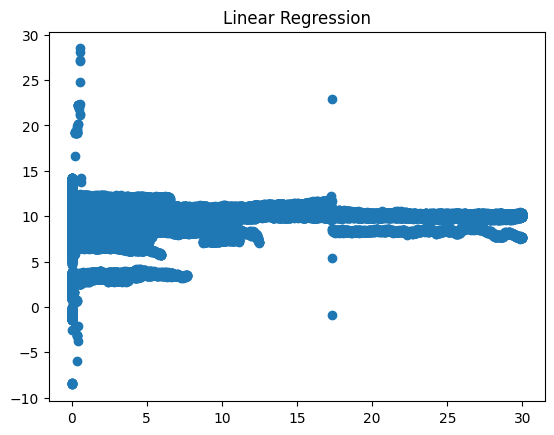

average prediction:  8.376707108738579, std: 2.8549650753757745
min prediction:  -8.550264825757234, max prediction: 28.475501978459533
{'MSE': 72.36673332516173, 'MAE': 7.625421313300662, 'R2': -0.6547291801246231}
--------------------------------------
Run time: 0.01 minutes
Current Time: 14:52:23
--------------------------------------

Current Time: 14:52:23
results for target: hours_to_hazard, model: K-Nearest Neighbors Regressor


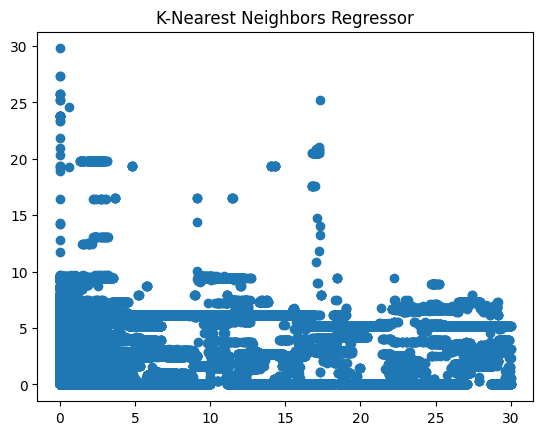

average prediction:  2.2738103747805787, std: 2.4915712252829927
min prediction:  0.0, max prediction: 29.78333333333333
{'MSE': 47.29956776744261, 'MAE': 3.954128075667916, 'R2': -0.08154633207487594}
--------------------------------------
Run time: 0.02 minutes
Current Time: 14:52:24
--------------------------------------

Current Time: 14:52:24
results for target: hours_to_hazard, model: Random Forest Regressor


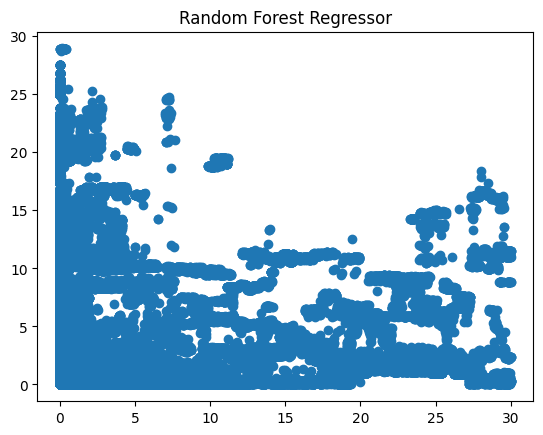

average prediction:  4.7384925071692185, std: 5.931371306078472
min prediction:  0.0, max prediction: 28.936833333333315
{'MSE': 82.98308769774368, 'MAE': 5.990022071515246, 'R2': -0.8974814857720432}
--------------------------------------
Run time: 0.58 minutes
Current Time: 14:52:58
--------------------------------------

Current Time: 14:52:58
results for target: hours_to_hazard, model: Support Vector Regressor


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import seaborn as sns
import matplotlib.pyplot as plt

import time
import pickle

print('input variables:')
for var in model_input.columns:
    print(var)

print('here first')
# Define the models to test
models = {
    'Linear Regression': LinearRegression(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Support Vector Regressor': SVR(),

    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(16, 32), max_iter=1000)
}

print('here')

# Dictionary to hold the results
results = {}
output_models = {}

saved_processed_data = {}

# Iterate over the models, fit, and evaluate them
start_time = time.time()
results = dict()

targ = 'hours_to_hazard'

results[targ] = dict()
output_models[targ] = dict()
#y = model_output[targ].values

X_train = model_input_train[model_output_train[targ].notnull()].values
X_test = model_input_test[model_output_test[targ].notnull()].values

Y_train = model_output_train[model_output_train[targ].notnull()][targ].values
Y_test = model_output_test[model_output_test[targ].notnull()][targ].values

# Split the data into training and testing sets
#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#n_true = np.sum((Y_train == 1))
#n_false = np.sum((Y_train == 0))

#print(f'balanced true samples: {n_true}, balanced false samples: {n_false}')
for name, model in models.items():
    print()
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print(f'results for target: {targ}, model: {name}')
    model.fit(X_train, Y_train)
    output_models[targ][name] = model

    predictions = model.predict(X_test)
    
    plt.scatter(Y_test, predictions)
    plt.title(f'{name}')
    plt.show()
    
    print(f'average prediction:  {np.mean(predictions)}, std: {np.std(predictions)}')
    print(f'min prediction:  {np.min(predictions)}, max prediction: {np.max(predictions)}')
    
    mse = mean_squared_error(Y_test, predictions)
    mae = mean_absolute_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)
    
    results[targ][name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

    print(results[targ][name])
    print('--------------------------------------')

    duration = time.time() - start_time
    print(f"Run time: {duration / 60:.2f} minutes")
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print('--------------------------------------')

In [ ]:
with open(f'models/regression_models_base_only_{extruder}_{hours_threshold}H.pkl', 'wb') as f:
    pickle.dump((output_models, results), f)

In [47]:
target_features = ['hours_to_hazard']
input_features = [
    'Screw Speed Output',
    'Screw Speed',
    'Extruder Die Temp',
    'Extruder Thrust',
    'Feed Screw Current (Amps)',
    'Discharge Conveyor Current (Amps)',
    'Discharge Conveyor Speed (%)',
    'pressure-15min_avg',
    'pressure-30min_avg',
    'pressure-1hour_avg',
    'pressure-3hour_avg',
    'pressure-6hour_avg',
    'pressure-12hour_avg',
    'pressure-24hour_avg',
    'pressure-48hour_avg',
    'pressure-5min_var',
    'pressure-15min_var',
    'pressure-30min_var',
    'pressure-1hour_var',
    'pressure-3hour_var',
    'pressure-6hour_var',
    'pressure-12hour_var',
    'pressure-24hour_var',
    'pressure-48hour_var',
    'die_temp-15min_avg',
    'thrust-15min_avg',
    'screw_speed_output-15min_avg',
    'die_temp-1hour_avg',
    'thrust-1hour_avg',
    'screw_speed_output-1hour_avg',
    'die_temp-3hour_avg',
    'thrust-3hour_avg',
    'screw_speed_output-3hour_avg',
]

In [48]:
#model_input = ex_data[ex_data['hours_to_next_pause'] <= 6][input_features]
#model_output = ex_data[ex_data['hours_to_next_pause'] <= 6][target_features]

In [49]:
train_split_cutoff = pd.to_datetime('12/1/2023')
model_input_train = model_input[model_input.index < train_split_cutoff]
model_input_test = model_input[model_input.index >= train_split_cutoff]

model_output_train = model_output[model_output.index < train_split_cutoff]
model_output_test = model_output[model_output.index >= train_split_cutoff]

In [50]:
print('input variables:')
for var in model_input.columns:
    print(var)

# Define the models to test
models = {
    'Linear Regression': LinearRegression(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Support Vector Regressor': SVR(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(16, 32), max_iter=1000)
}

# Dictionary to hold the results
results = {}
output_models = {}

saved_processed_data = {}

# Iterate over the models, fit, and evaluate them
start_time = time.time()
results = dict()

targ = 'hours_to_next_pause'

results[targ] = dict()
output_models[targ] = dict()
#y = model_output[targ].values

X_train = model_input_train[model_output_train[targ].notnull()].values
X_test = model_input_test[model_output_test[targ].notnull()].values

Y_train = model_output_train[model_output_train[targ].notnull()][targ].values
Y_test = model_output_test[model_output_test[targ].notnull()][targ].values

# Split the data into training and testing sets
#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n_true = np.sum((Y_train == 1))
n_false = np.sum((Y_train == 0))

print(f'balanced true samples: {n_true}, balanced false samples: {n_false}')
for name, model in models.items():
    print()
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print(f'results for target: {targ}, model: {name}')
    model.fit(X_train, Y_train)
    output_models[targ][name] = model

    predictions = model.predict(X_test)
    
    plt.scatter(Y_test, predictions)
    plt.title(f'{name}')
    plt.show()
    
    print(f'average prediction:  {np.mean(predictions)}, std: {np.std(predictions)}')
    print(f'min prediction:  {np.min(predictions)}, max prediction: {np.max(predictions)}')

    mse = mean_squared_error(Y_test, predictions)
    mae = mean_absolute_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)

    results[targ][name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

    print(results[targ][name])
    print('--------------------------------------')

    duration = time.time() - start_time
    print(f"Run time: {duration / 60:.2f} minutes")
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print('--------------------------------------')

input variables:
Screw Speed Output
Screw Speed
Extruder Die Temp
Extruder Thrust 
Feed Screw Current (Amps)
Discharge Conveyor Current (Amps)
Discharge Conveyor Speed (%)
pressure-5min_avg
pressure-15min_avg
pressure-30min_avg
pressure-1hour_avg
pressure-3hour_avg
pressure-6hour_avg
pressure-12hour_avg
pressure-24hour_avg
pressure-48hour_avg
pressure-5min_var
pressure-15min_var
pressure-30min_var
pressure-1hour_var
pressure-3hour_var
pressure-6hour_var
pressure-12hour_var
pressure-24hour_var
pressure-48hour_var
die_temp-15min_avg
thrust-15min_avg
die_temp-1hour_avg
thrust-1hour_avg
die_temp-3hour_avg
thrust-3hour_avg
die_temp-6hour_avg
thrust-6hour_avg


KeyError: 'hours_to_next_pause'

In [ ]:
with open(f'models/regression_models_with_screw_speed_no_5T_{extruder}_12H.pkl', 'wb') as f:
    pickle.dump((output_models, results), f)

In [ ]:
def clean_extruder_data_old(extruder_data):
    
    extruder_data = extruder_data.drop(extruder_data.index[0])
    extruder_data = extruder_data.replace("<null>", None)
    
    extruder_data = extruder_data.dropna()

    # Convert the column to string type
    for column in extruder_data.columns:
        if column not in ["Date and Time", "AnomalyScore"]:
            extruder_data[column] = extruder_data[column].astype(str)
            #extruder_data[column] = extruder_data[column].str.replace("<null>", None)
            # Replace commas with an empty string
            extruder_data[column] = extruder_data[column].str.replace(",", "")

            # Convert the column back to numeric type, handling any conversion errors
            extruder_data[column] = pd.to_numeric(extruder_data[column], errors="coerce")
            
    extruder_data = extruder_data[(extruder_data['Extruder Pressure'] >= 0) & \
                              (extruder_data['Extruder Pressure'] < 50000)]

    extruder_data['Date and Time'] = pd.to_datetime(extruder_data['Date and Time'])
    
    return extruder_data